In [1]:
import sys
sys.path.append('..')
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sympy import simplify_logic
import time
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import _tree, export_text
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from deep_logic.utils.base import validate_network, set_seed, tree_to_formula
from deep_logic.utils.relunn import get_reduced_model, prune_features
from deep_logic.utils.sigmoidnn import prune_equal_fanin
from deep_logic import logic

results_dir = 'results/mnist_h'
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_rep = 10
tot_epochs = 4001
prune_epochs = 2000

In [2]:
# MNIST problem
num_workers = 0
batch_size = 128
valid_size = 0.2
# Data augmentation for train data + conversion to tensor
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
   
])# Data augmentation for test data + conversion to tensor
test_transforms= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

In [3]:
# Finding indices for validation set
num_train = len(train_data)
indices = list(range(num_train))
#Randomize indices
np.random.shuffle(indices)
split = int(np.floor(num_train*valid_size))
train_index, test_index = indices[split:], indices[:split]# Making samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(test_index)# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = torch.nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(8, 16, 3, padding =1)
        # linear layers
        self.fc1 = torch.nn.Linear(784, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.fc4 = torch.nn.Linear(64, 2) 
        # dropout
        self.dropout = torch.nn.Dropout(p=0.2)
        # max pooling
        self.pool = torch.nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flattening the image
        x = x.view(-1, 7*7*16)
        # linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return F.softmax(x, dim=1)
        
model = Net()
print(model)
model.cuda()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
criterion = torch.nn.CrossEntropyLoss()
if os.path.isfile('trained_model_h.pt'):
    model.load_state_dict(torch.load('trained_model_h.pt'))

else:
    # epochs to train for
    epochs = 10
    set_seed(0)

    # tracks validation loss change after each epoch
    minimum_validation_loss = np.inf 

    #optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):

        train_loss = 0
        valid_loss = 0

        # training steps
        model.train()
        for batch_index, (data, target) in enumerate(train_loader):
            # moves tensors to GPU
            data, target = data.cuda(), target.cuda() % 2
            # clears gradients
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # loss in batch
            loss = criterion(output, target)
            # backward pass for loss gradient
            loss.backward()
            # update paremeters
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

        # validation steps
        model.eval()
        for batch_index, (data, target) in enumerate(valid_loader):
            # moves tensors to GPU
            data, target = data.cuda(), target.cuda() % 2
            # forward pass
            output = model(data)
            # loss in batch
            loss = criterion(output, target)
            # update validation loss
            valid_loss += loss.item()*data.size(0)

        # average loss calculations
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        # Display loss statistics
        print(f'Current Epoch: {epoch}\nTraining Loss: {round(train_loss, 6)}\nValidation Loss: {round(valid_loss, 6)}')

        # Saving model every time validation loss decreases
        if valid_loss <= minimum_validation_loss and epoch > 5:
            print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
            torch.save(model.state_dict(), 'trained_model_h.pt')
            minimum_validation_loss = valid_loss
            print('Saving New Model')
    
    model.load_state_dict(torch.load('trained_model_h.pt'))

In [6]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
classes = [0, 1]
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU
    data, target = data.cuda(), target.cuda() % 2
    # forward pass
    output = model(data)
    # batch loss
    loss = criterion(output, target)
    # test loss update
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(2):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print(f'Test Loss: {round(test_loss, 6)}')

for i in range(2):
    if class_total[i] > 0:
        print(f'Test Accuracy of {classes[i]}: {round(100*class_correct[i]/class_total[i], 2)}%')
    else:
        print(f'Test Accuracy of {classes[i]}s: N/A (no training examples)')
        
        
print(f'Full Test Accuracy: {round(100. * np.sum(class_correct) / np.sum(class_total), 2)}% {np.sum(class_correct)} out of {np.sum(class_total)}')

Test Loss: 0.320503
Test Accuracy of 0: 100.0%
Test Accuracy of 1: 97.4%
Full Test Accuracy: 98.73% 156.0 out of 158.0


# Extract concepts from hidden layers

In [7]:
pred_h_train = []
true_y_train = []
model.eval()
model = model.cpu()
for batch_index, (data, target) in enumerate(train_loader):
    # moves tensors to GPU
    data, target = data.cpu(), target.cpu() % 2
    # forward pass
    #output = model(data)
    #pred = torch.argmax(output, 1)
    
    # get hidden layer's projection of the input
    x = model.pool(F.relu(model.conv1(data)))
    x = model.pool(F.relu(model.conv2(x)))
    # flattening the image
    x = x.view(-1, 7*7*16)
    # linear layers
    x = model.dropout(F.relu(model.fc1(x)))
    x = model.dropout(F.relu(model.fc2(x)))
    
    pred_h_train.append(x.cpu())
    true_y_train.append(target.cpu())

pred_h_train = torch.cat(pred_h_train)
true_y_train = torch.cat(true_y_train)
print(pred_h_train.shape)
print(true_y_train.shape)

torch.Size([48000, 128])
torch.Size([48000])


In [8]:
pred_h_test = []
true_y_test = []
model.eval()
model = model.cpu()
for batch_index, (data, target) in enumerate(test_loader):
    # moves tensors to GPU
    data, target = data.cpu(), target.cpu() % 2
    # forward pass
    #output = model(data)
    #pred = torch.argmax(output, 1)
    
    # get hidden layer's projection of the input
    x = model.pool(F.relu(model.conv1(data)))
    x = model.pool(F.relu(model.conv2(x)))
    # flattening the image
    x = x.view(-1, 7*7*16)
    # linear layers
    x = model.dropout(F.relu(model.fc1(x)))
    x = model.dropout(F.relu(model.fc2(x)))
    
    pred_h_test.append(x.cpu())
    true_y_test.append(target.cpu())

pred_h_test = torch.cat(pred_h_test)
true_y_test = torch.cat(true_y_test)
print(pred_h_test.shape)
print(true_y_test.shape)

torch.Size([10000, 128])
torch.Size([10000])


In [9]:
X_embedded = TSNE(n_components=2).fit_transform(pred_h_train.detach().numpy())

In [10]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(pred_h_train.detach().numpy())
X_train = kmeans.predict(pred_h_train.detach().numpy())
X_test = kmeans.predict(pred_h_test.detach().numpy())
print(X_train.shape)
print(X_test.shape)

(48000,)
(10000,)


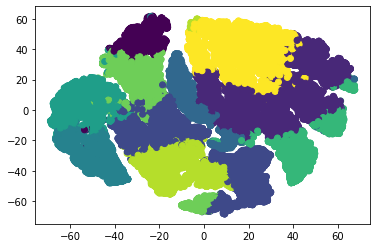

In [11]:
plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=X_train)
plt.show()

## Prepare data

In [12]:
x_train = torch.FloatTensor(OneHotEncoder(sparse=False).fit_transform(X_train.reshape(-1, 1)))
x_test = torch.FloatTensor(OneHotEncoder(sparse=False).fit_transform(X_test.reshape(-1, 1)))
print(x_train.shape)
print(x_test.shape)

torch.Size([48000, 10])
torch.Size([10000, 10])


In [13]:
y_train = (true_y_train % 2 == 1).to(torch.long)
y_test = (true_y_test % 2 == 1).to(torch.long)
print(y_train.shape)
print(y_test.shape)

torch.Size([48000])
torch.Size([10000])


In [14]:
concepts = [f'h{i}' for i in range(x_train.shape[1])]
concepts

['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9']

## Training loop

In [15]:
def train_nn(x_train, y_train, need_pruning, seed, device):
    set_seed(seed)
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    layers = [
        torch.nn.Linear(x_train.size(1), 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 30),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(30, 2),
        torch.nn.Softmax(dim=1),
    ]
    model = torch.nn.Sequential(*layers).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    loss_form = torch.nn.CrossEntropyLoss()
    model.train()
    for epoch in range(tot_epochs):
        # forward pass
        optimizer.zero_grad()
        y_pred = model(x_train)
        # Compute Loss
        loss = loss_form(y_pred, y_train)

        for module in model.children():
            if isinstance(module, torch.nn.Linear):
                loss += 0.01 * torch.norm(module.weight, 1)
                loss += 0.01 * torch.norm(module.bias, 1)
                break

        # backward pass
        loss.backward()
        optimizer.step()

        if epoch > prune_epochs and need_pruning:
            prune_features(model, n_classes=1, device=device)
            need_pruning = False
            
        # compute accuracy
        if epoch % 500 == 0:
            y_pred_d = torch.argmax(y_pred, dim=1)
            accuracy = y_pred_d.eq(y_train).sum().item() / y_train.size(0)
            print(f'\t Epoch {epoch}: train accuracy: {accuracy:.4f}')
    
    return model

# General pruning

In [16]:
need_pruning = True
method = 'pruning'
methods = []
splits = []
explanations = []
explanations_inv = []
model_accuracies = []
explanation_accuracies = []
explanation_accuracies_inv = []
elapsed_times = []
elapsed_times_inv = []
for seed in range(n_rep):
    print(f'Seed [{seed+1}/{n_rep}]')
    
    model = train_nn(x_train, y_train, need_pruning, seed, device)
    
    y_preds = model(x_test.to(device)).cpu().detach().numpy()
    model_accuracy = accuracy_score(y_test.cpu().detach().numpy(), y_preds.argmax(axis=1))
    print(f'\t Model\'s accuracy: {model_accuracy:.4f}')
    
    # positive class
    target_class = 1
    start = time.time()
    global_explanation, _, _ = logic.relunn.combine_local_explanations(model, 
                                                                       x_train.to(device), y_train.to(device), 
                                                                       target_class=target_class,
                                                                       topk_explanations=10,
                                                                       method=method, device=device)
    elapsed_time = time.time() - start
    if global_explanation:
        explanation_accuracy, _ = logic.base.test_explanation(global_explanation, target_class, x_test, y_test)
        explanation = logic.base.replace_names(global_explanation, concepts)
    print(f'\t Class {target_class} - Global explanation: "{explanation}" - Accuracy: {explanation_accuracy:.4f}')
    print(f'\t Elapsed time {elapsed_time}')
        
    # negative class
    target_class = 0
    start = time.time()
    global_explanation_inv, _, _ = logic.relunn.combine_local_explanations(model, 
                                                                           x_train.to(device), y_train.to(device), 
                                                                           target_class=target_class,
                                                                           topk_explanations=10,
                                                                           method=method, device=device)
    elapsed_time_inv = time.time() - start
    if global_explanation_inv:
        explanation_accuracy_inv, _ = logic.base.test_explanation(global_explanation_inv, target_class, x_test, y_test)
        explanation_inv = logic.base.replace_names(global_explanation_inv, concepts)
    print(f'\t Class {target_class} - Global explanation: "{explanation_inv}" - Accuracy: {explanation_accuracy_inv:.4f}')
    print(f'\t Elapsed time {elapsed_time_inv}')
    
    methods.append(method)
    splits.append(seed)
    explanations.append(explanation)
    explanations_inv.append(explanation_inv)
    model_accuracies.append(model_accuracy)
    explanation_accuracies.append(explanation_accuracy)
    explanation_accuracies_inv.append(explanation_accuracy_inv)
    elapsed_times.append(elapsed_time)
    elapsed_times_inv.append(elapsed_time_inv)

Seed [1/10]
	 Epoch 0: train accuracy: 0.4910
	 Epoch 500: train accuracy: 0.9939
	 Epoch 1000: train accuracy: 0.9939
	 Epoch 1500: train accuracy: 0.9939
	 Epoch 2000: train accuracy: 0.9939
	 Epoch 2500: train accuracy: 0.9939
	 Epoch 3000: train accuracy: 0.9939
	 Epoch 3500: train accuracy: 0.9939
	 Epoch 4000: train accuracy: 0.9939
	 Model's accuracy: 0.9928
~feature0000000001 & ~feature0000000003 & ~feature0000000006 & ~feature0000000009
	 Class 1 - Global explanation: "~h1 & ~h3 & ~h6 & ~h9" - Accuracy: 0.9928
	 Elapsed time 65.44997954368591
feature0000000001 | feature0000000003 | feature0000000006 | feature0000000009
	 Class 0 - Global explanation: "h1 | h3 | h6 | h9" - Accuracy: 0.9928
	 Elapsed time 51.40061378479004
Seed [2/10]
	 Epoch 0: train accuracy: 0.4910
	 Epoch 500: train accuracy: 0.9939
	 Epoch 1000: train accuracy: 0.9939
	 Epoch 1500: train accuracy: 0.9939
	 Epoch 2000: train accuracy: 0.9939
	 Epoch 2500: train accuracy: 0.9939
	 Epoch 3000: train accuracy: 

In [17]:
results_pruning = pd.DataFrame({
    'method': methods,
    'split': splits,
    'explanation': explanations,
    'explanation_inv': explanations_inv,
    'model_accuracy': model_accuracies,
    'explanation_accuracy': explanation_accuracies,
    'explanation_accuracy_inv': explanation_accuracies_inv,
    'elapsed_time': elapsed_times,
    'elapsed_time_inv': elapsed_times_inv,
})
results_pruning.to_csv(os.path.join(results_dir, 'results_pruning.csv'))
results_pruning

,method,split,explanation,explanation_inv,model_accuracy,explanation_accuracy,explanation_accuracy_inv,elapsed_time,elapsed_time_inv
0,pruning,0,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,65.449980,51.400614
1,pruning,1,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,50.679115,58.627301
2,pruning,2,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,57.362711,58.145587
3,pruning,3,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,61.273226,49.233447
4,pruning,4,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,58.926335,58.849749
5,pruning,5,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,57.387614,56.041210
6,pruning,6,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,55.668366,61.187489
7,pruning,7,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,60.258937,53.016431
8,pruning,8,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,58.359018,59.105026
9,pruning,9,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,62.157902,58.625306


# LIME

In [18]:
# need_pruning = False
# method = 'lime'
# methods = []
# splits = []
# explanations = []
# explanations_inv = []
# model_accuracies = []
# explanation_accuracies = []
# explanation_accuracies_inv = []
# elapsed_times = []
# elapsed_times_inv = []
# for seed in range(n_rep):
#     print(f'Seed [{seed+1}/{n_rep}]')
    
#     model = train_nn(x_train, y_train, need_pruning, seed, device)
    
#     y_preds = model(x_test.to(device)).cpu().detach().numpy()
#     model_accuracy = accuracy_score(y_test.cpu().detach().numpy(), y_preds.argmax(axis=1))
#     print(f'\t Model\'s accuracy: {model_accuracy:.4f}')
    
#     # positive class
#     target_class = 1
#     start = time.time()
#     global_explanation, _, _ = logic.relunn.combine_local_explanations(model, 
#                                                                        x_train.to(device), y_train.to(device), 
#                                                                        target_class=target_class,
#                                                                        method=method, device=device)
#     elapsed_time = time.time() - start
#     if global_explanation:
#         explanation_accuracy, _ = logic.base.test_explanation(global_explanation, target_class, x_test, y_test)
#         explanation = logic.base.replace_names(global_explanation, concepts)
#     print(f'\t Class {target_class} - Global explanation: "{explanation}" - Accuracy: {explanation_accuracy:.4f}')
#     print(f'\t Elapsed time {elapsed_time}')
        
#     # negative class
#     target_class = 0
#     start = time.time()
#     global_explanation_inv, _, _ = logic.relunn.combine_local_explanations(model, 
#                                                                            x_train.to(device), y_train.to(device), 
#                                                                            target_class=target_class,
#                                                                            method=method, device=device)
#     elapsed_time_inv = time.time() - start
#     if global_explanation_inv:
#         explanation_accuracy_inv, _ = logic.base.test_explanation(global_explanation_inv, target_class, x_test, y_test)
#         explanation_inv = logic.base.replace_names(global_explanation_inv, concepts)
#     print(f'\t Class {target_class} - Global explanation: "{explanation_inv}" - Accuracy: {explanation_accuracy_inv:.4f}')
#     print(f'\t Elapsed time {elapsed_time_inv}')
    
#     methods.append(method)
#     splits.append(seed)
#     explanations.append(explanation)
#     explanations_inv.append(explanation_inv)
#     model_accuracies.append(model_accuracy)
#     explanation_accuracies.append(explanation_accuracy)
#     explanation_accuracies_inv.append(explanation_accuracy_inv)
#     elapsed_times.append(elapsed_time)
#     elapsed_times_inv.append(elapsed_time_inv)

In [19]:
# results_lime = pd.DataFrame({
#     'method': methods,
#     'split': splits,
#     'explanation': explanations,
#     'explanation_inv': explanations_inv,
#     'model_accuracy': model_accuracies,
#     'explanation_accuracy': explanation_accuracies,
#     'explanation_accuracy_inv': explanation_accuracies_inv,
#     'elapsed_time': elapsed_times,
#     'elapsed_time_inv': elapsed_times_inv,
# })
# results_lime.to_csv(os.path.join(results_dir, 'results_lime.csv'))
# results_lime

# Weights

In [20]:
need_pruning = False
method = 'weights'
methods = []
splits = []
explanations = []
explanations_inv = []
model_accuracies = []
explanation_accuracies = []
explanation_accuracies_inv = []
elapsed_times = []
elapsed_times_inv = []
for seed in range(n_rep):
    print(f'Seed [{seed+1}/{n_rep}]')
    
    model = train_nn(x_train, y_train, need_pruning, seed, device)
    
    y_preds = model(x_test.to(device)).cpu().detach().numpy()
    model_accuracy = accuracy_score(y_test.cpu().detach().numpy(), y_preds.argmax(axis=1))
    print(f'\t Model\'s accuracy: {model_accuracy:.4f}')
    
    # positive class
    target_class = 1
    start = time.time()
    global_explanation, _, _ = logic.relunn.combine_local_explanations(model, 
                                                                       x_train.to(device), y_train.to(device),
                                                                       topk_explanations=10, 
                                                                       target_class=target_class,
                                                                       method=method, device=device)
    elapsed_time = time.time() - start
    if global_explanation:
        explanation_accuracy, _ = logic.base.test_explanation(global_explanation, target_class, x_test, y_test)
        explanation = logic.base.replace_names(global_explanation, concepts)
    print(f'\t Class {target_class} - Global explanation: "{explanation}" - Accuracy: {explanation_accuracy:.4f}')
    print(f'\t Elapsed time {elapsed_time}')
        
    # negative class
    target_class = 0
    start = time.time()
    global_explanation_inv, _, _ = logic.relunn.combine_local_explanations(model, 
                                                                           x_train.to(device), y_train.to(device), 
                                                                           topk_explanations=10, 
                                                                           target_class=target_class,
                                                                           method=method, device=device)
    elapsed_time_inv = time.time() - start
    if global_explanation_inv:
        explanation_accuracy_inv, _ = logic.base.test_explanation(global_explanation_inv, target_class, x_test, y_test)
        explanation_inv = logic.base.replace_names(global_explanation_inv, concepts)
    print(f'\t Class {target_class} - Global explanation: "{explanation_inv}" - Accuracy: {explanation_accuracy_inv:.4f}')
    print(f'\t Elapsed time {elapsed_time_inv}')
    
    methods.append(method)
    splits.append(seed)
    explanations.append(explanation)
    explanations_inv.append(explanation_inv)
    model_accuracies.append(model_accuracy)
    explanation_accuracies.append(explanation_accuracy)
    explanation_accuracies_inv.append(explanation_accuracy_inv)
    elapsed_times.append(elapsed_time)
    elapsed_times_inv.append(elapsed_time_inv)

Seed [1/10]
	 Epoch 0: train accuracy: 0.4910
	 Epoch 500: train accuracy: 0.9939
	 Epoch 1000: train accuracy: 0.9939
	 Epoch 1500: train accuracy: 0.9939
	 Epoch 2000: train accuracy: 0.9939
	 Epoch 2500: train accuracy: 0.9939
	 Epoch 3000: train accuracy: 0.9939
	 Epoch 3500: train accuracy: 0.9939
	 Epoch 4000: train accuracy: 0.9939
	 Model's accuracy: 0.9928
~feature0000000001 & ~feature0000000003 & ~feature0000000006 & ~feature0000000009
	 Class 1 - Global explanation: "~h1 & ~h3 & ~h6 & ~h9" - Accuracy: 0.9928
	 Elapsed time 112.44951820373535
feature0000000001 | feature0000000003 | feature0000000006 | (~feature0000000000 & ~feature0000000002 & ~feature0000000004 & ~feature0000000007 & ~feature0000000008)
	 Class 0 - Global explanation: "h1 | h3 | h6 | (~h0 & ~h2 & ~h4 & ~h7 & ~h8)" - Accuracy: 0.9085
	 Elapsed time 114.9409294128418
Seed [2/10]
	 Epoch 0: train accuracy: 0.4910
	 Epoch 500: train accuracy: 0.9939
	 Epoch 1000: train accuracy: 0.9939
	 Epoch 1500: train accura

In [21]:
results_weights = pd.DataFrame({
    'method': methods,
    'split': splits,
    'explanation': explanations,
    'explanation_inv': explanations_inv,
    'model_accuracy': model_accuracies,
    'explanation_accuracy': explanation_accuracies,
    'explanation_accuracy_inv': explanation_accuracies_inv,
    'elapsed_time': elapsed_times,
    'elapsed_time_inv': elapsed_times_inv,
})
results_weights.to_csv(os.path.join(results_dir, 'results_weights.csv'))
results_weights

,method,split,explanation,explanation_inv,model_accuracy,explanation_accuracy,explanation_accuracy_inv,elapsed_time,elapsed_time_inv
0,weights,0,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | (~h0 & ~h2 & ~h4 & ~h7 & ~h8),0.9928,0.9928,0.9085,112.449518,114.940929
1,weights,1,h2 | ~h6,h1 | h3 | h6 | h9,0.9928,0.4179,0.9928,111.515938,104.967473
2,weights,2,h2 | h7 | h8 | (~h1 & ~h3 & ~h6 & ~h9),h1 | h3 | h6 | h9,0.9928,0.6776,0.9928,112.242993,106.871387
3,weights,3,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,115.072605,108.202754
4,weights,4,(~h3 & ~h7) | (~h1 & ~h3 & ~h6 & ~h9),h1 | h3 | h6 | h9,0.9928,0.1530,0.9928,107.582190,107.011978
5,weights,5,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,116.756913,119.553458
6,weights,6,h2 | (~h1 & ~h3 & ~h6 & ~h9),h1 | h3 | h6 | h9,0.9928,0.8347,0.9928,117.111979,106.373715
7,weights,7,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,125.108504,114.832179
8,weights,8,(~h0 & ~h1 & ~h2) | (~h1 & ~h3 & ~h6 & ~h9),h1 | h3 | h6 | h9,0.9928,0.4102,0.9928,119.238300,114.384273
9,weights,9,~h1 & ~h3 & ~h6 & ~h9,h1 | h3 | h6 | h9,0.9928,0.9928,0.9928,112.362678,111.743952


# Psi network

In [22]:
def train_psi_nn(x_train, y_train, need_pruning, seed, device):
    set_seed(seed)
    x_train = x_train.to(device)
    y_train = y_train.to(device).to(torch.float)
    layers = [
        torch.nn.Linear(x_train.size(1), 10),
        torch.nn.Sigmoid(),
        torch.nn.Linear(10, 4),
        torch.nn.Sigmoid(),
        torch.nn.Linear(4, 1),
        torch.nn.Sigmoid(),
    ]
    model = torch.nn.Sequential(*layers).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_form = torch.nn.BCELoss()
    model.train()
    for epoch in range(tot_epochs):
        # forward pass
        optimizer.zero_grad()
        y_pred = model(x_train).squeeze()
        # Compute Loss
        loss = loss_form(y_pred, y_train)

        for module in model.children():
            if isinstance(module, torch.nn.Linear):
                loss += 0.00001 * torch.norm(module.weight, 1)

        # backward pass
        loss.backward()
        optimizer.step()

        if epoch > prune_epochs and need_pruning:
            model = prune_equal_fanin(model, 2, validate=True, device=device)
            need_pruning = False
            
        # compute accuracy
        if epoch % 500 == 0:
            y_pred_d = y_pred > 0.5
            accuracy = y_pred_d.eq(y_train).sum().item() / y_train.size(0)
            print(f'\t Epoch {epoch}: train accuracy: {accuracy:.4f}')
    
    return model

In [23]:
need_pruning = True
method = 'psi'
methods = []
splits = []
explanations = []
explanations_inv = []
model_accuracies = []
explanation_accuracies = []
explanation_accuracies_inv = []
elapsed_times = []
elapsed_times_inv = []
for seed in range(n_rep):
    print(f'Seed [{seed+1}/{n_rep}]')
    
    # positive class
    target_class = 1
    model = train_psi_nn(x_train, y_train, need_pruning, seed, device)
    
    y_preds = model(x_test.to(device)).cpu().detach().numpy()
    model_accuracy = accuracy_score(y_test.cpu().detach().numpy(), y_preds > 0.5)
    print(f'\t Model\'s accuracy: {model_accuracy:.4f}')
    
    start = time.time()
    global_explanation = logic.generate_fol_explanations(model, device)[0]
    elapsed_time = time.time() - start
    explanation_accuracy, _ = logic.base.test_explanation(global_explanation, target_class, x_test, y_test)
    explanation = logic.base.replace_names(global_explanation, concepts)
    print(f'\t Class {target_class} - Global explanation: "{explanation}" - Accuracy: {explanation_accuracy:.4f}')
    print(f'\t Elapsed time {elapsed_time}')
        
    # negative class
    target_class = 0
    model = train_psi_nn(x_train, y_train.eq(target_class), need_pruning, seed, device)
    
    y_preds = model(x_test.to(device)).cpu().detach().numpy()
    model_accuracy = accuracy_score(y_test.eq(target_class).cpu().detach().numpy(), y_preds > 0.5)
    print(f'\t Model\'s accuracy: {model_accuracy:.4f}')
    
    start = time.time()
    global_explanation_inv = logic.generate_fol_explanations(model, device)[0]
    elapsed_time_inv = time.time() - start
    explanation_accuracy_inv, _ = logic.base.test_explanation(global_explanation_inv, 
                                                              target_class, x_test, y_test)
    explanation_inv = logic.base.replace_names(global_explanation_inv, concepts)
    print(f'\t Class {target_class} - Global explanation: "{explanation_inv}" - Accuracy: {explanation_accuracy_inv:.4f}')
    print(f'\t Elapsed time {elapsed_time_inv}')
    
    methods.append(method)
    splits.append(seed)
    explanations.append(explanation)
    explanations_inv.append(explanation_inv)
    model_accuracies.append(model_accuracy)
    explanation_accuracies.append(explanation_accuracy)
    explanation_accuracies_inv.append(explanation_accuracy_inv)
    elapsed_times.append(elapsed_time)
    elapsed_times_inv.append(elapsed_time_inv)

Seed [1/10]
	 Epoch 0: train accuracy: 0.4910
	 Epoch 500: train accuracy: 0.9939
	 Epoch 1000: train accuracy: 0.9939
	 Epoch 1500: train accuracy: 0.9939
	 Epoch 2000: train accuracy: 0.9939
	 Epoch 2500: train accuracy: 0.7683
	 Epoch 3000: train accuracy: 0.7683
	 Epoch 3500: train accuracy: 0.7683
	 Epoch 4000: train accuracy: 0.7683
	 Model's accuracy: 0.7614
	 Class 1 - Global explanation: "(h0 | h2 | ~h1)" - Accuracy: 0.5202
	 Elapsed time 0.0747995376586914
	 Epoch 0: train accuracy: 0.5090
	 Epoch 500: train accuracy: 0.9939
	 Epoch 1000: train accuracy: 0.9939
	 Epoch 1500: train accuracy: 0.9939
	 Epoch 2000: train accuracy: 0.9939
	 Epoch 2500: train accuracy: 0.7107
	 Epoch 3000: train accuracy: 0.7107
	 Epoch 3500: train accuracy: 0.7107
	 Epoch 4000: train accuracy: 0.7107
	 Model's accuracy: 0.7143
	 Class 0 - Global explanation: "(~h4 & ~h5 & (h6 | ~h7))" - Accuracy: 0.5663
	 Elapsed time 0.08178138732910156
Seed [2/10]
	 Epoch 0: train accuracy: 0.4910
	 Epoch 500: t

	 Epoch 1500: train accuracy: 0.9939
	 Epoch 2000: train accuracy: 0.9939
	 Epoch 2500: train accuracy: 0.7836
	 Epoch 3000: train accuracy: 0.7836
	 Epoch 3500: train accuracy: 0.7836
	 Epoch 4000: train accuracy: 0.7836
	 Model's accuracy: 0.7849
	 Class 0 - Global explanation: "((h9 | ~h0) & (h9 | ~h5) & (h3 | h6 | h9) & (~h0 | ~h7) & (~h5 | ~h7) & (h3 | h6 | ~h7))" - Accuracy: 0.5663
	 Elapsed time 0.15259170532226562
Seed [10/10]
	 Epoch 0: train accuracy: 0.4910
	 Epoch 500: train accuracy: 0.9939
	 Epoch 1000: train accuracy: 0.9939
	 Epoch 1500: train accuracy: 0.9939
	 Epoch 2000: train accuracy: 0.9939
	 Epoch 2500: train accuracy: 0.4910
	 Epoch 3000: train accuracy: 0.6526
	 Epoch 3500: train accuracy: 0.9275
	 Epoch 4000: train accuracy: 0.9275
	 Model's accuracy: 0.9242
	 Class 1 - Global explanation: "(~h1 & ~h3 & (h2 | ~h9))" - Accuracy: 0.4861
	 Elapsed time 0.07875370979309082
	 Epoch 0: train accuracy: 0.5090
	 Epoch 500: train accuracy: 0.9939
	 Epoch 1000: train ac

In [24]:
results_psi = pd.DataFrame({
    'method': methods,
    'split': splits,
    'explanation': explanations,
    'explanation_inv': explanations_inv,
    'model_accuracy': model_accuracies,
    'explanation_accuracy': explanation_accuracies,
    'explanation_accuracy_inv': explanation_accuracies_inv,
    'elapsed_time': elapsed_times,
    'elapsed_time_inv': elapsed_times_inv,
})
results_psi.to_csv(os.path.join(results_dir, 'results_psi.csv'))
results_psi

,method,split,explanation,explanation_inv,model_accuracy,explanation_accuracy,explanation_accuracy_inv,elapsed_time,elapsed_time_inv
0,psi,0,(h0 | h2 | ~h1),(~h4 & ~h5 & (h6 | ~h7)),0.7143,0.5202,0.5663,0.074800,0.081781
1,psi,1,((h2 | h5) & (h2 | ~h1) & (h5 | ~h3) & (~h1 | ...,(~h4 & ~h5 & (h1 | h3)),0.7874,0.2847,0.7874,0.075799,0.054853
2,psi,2,(~h1 & (h2 | ~h9) & (h0 | h7 | ~h6)),(~h0 & ~h2 & ~h5 & ~h7),0.8457,0.3072,0.8457,0.089794,0.054852
3,psi,3,((h2 & h5) | (h2 & ~h3) | (h2 & ~h9) | (h5 & ~...,(h1 | h3 | h6 | h9),0.9928,0.4002,0.9928,0.230375,0.078820
4,psi,4,(~h1 & ~h6 & (h2 | h7)),(h1 | h9 | (h3 & ~h2 & ~h5)),0.9242,0.7244,0.9242,0.196474,0.130683
5,psi,5,(h2 & ~h6 & ~h9),(h9 & ~h5 & ~h7),0.7513,0.6507,0.6442,0.085772,0.046874
6,psi,6,(h0 | h2 | h5),(h6 | (h3 & ~h2 & ~h4)),0.7144,0.7720,0.6481,0.038864,0.144613
7,psi,7,(h2 & ~h3),(h3 | h6),0.6481,0.6507,0.6481,0.104704,0.054854
8,psi,8,((h2 | ~h9) & (h4 | ~h6) & (h5 | ~h1)),((h9 | ~h0) & (h9 | ~h5) & (h3 | h6 | h9) & (~...,0.7849,0.4092,0.5663,0.122673,0.152592
9,psi,9,(~h1 & ~h3 & (h2 | ~h9)),(~h4),0.7514,0.4861,0.5563,0.078754,0.034938


# Decision tree

In [29]:
need_pruning = False
method = 'decision_tree'
methods = []
splits = []
explanations = []
explanations_inv = []
model_accuracies = []
explanation_accuracies = []
explanation_accuracies_inv = []
elapsed_times = []
elapsed_times_inv = []
for seed in range(n_rep):
    print(f'Seed [{seed+1}/{n_rep}]')
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())
    y_preds = classifier.predict(x_test.cpu().detach().numpy())
    model_accuracy = accuracy_score(y_test.cpu().detach().numpy(), y_preds)
    print(f'\t Model\'s accuracy: {model_accuracy:.4f}')
    
    target_class = 1
    start = time.time()
    explanation = tree_to_formula(classifier, concepts, target_class)
    elapsed_time = time.time() - start
    print(f'\t Class {target_class} - Global explanation: {explanation}')
    print(f'\t Elapsed time {elapsed_time}')
    
    target_class = 0
    start = time.time()
    explanation_inv = tree_to_formula(classifier, concepts, target_class)
    elapsed_time_inv = time.time() - start
    print(f'\t Class {target_class} - Global explanation: {explanation_inv}')
    print(f'\t Elapsed time {elapsed_time_inv}')
    
    methods.append(method)
    splits.append(seed)
    explanations.append(explanation)
    explanations_inv.append(explanation_inv)
    model_accuracies.append(model_accuracy)
    explanation_accuracies.append(model_accuracy)
    explanation_accuracies_inv.append(model_accuracy)
    elapsed_times.append(0)
    elapsed_times_inv.append(0)

Seed [1/10]
	 Model's accuracy: 0.9928
	 Class 1 - Global explanation: (h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= 0.50 & h8 <= 0.50 & h2 <= 0.50 & h7 <= 0.50) | (h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= 0.50 & h8 <= 0.50 & h2 <= 0.50 & h7 > 0.50) | (h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= 0.50 & h8 <= 0.50 & h2 > 0.50) | (h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= 0.50 & h8 > 0.50)
	 Elapsed time 0.0
	 Class 0 - Global explanation: (h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0.50) | (h1 <= 0.50 & h9 <= 0.50 & h3 > 0.50) | (h1 <= 0.50 & h9 > 0.50) | (h1 > 0.50)
	 Elapsed time 0.0009636878967285156
Seed [2/10]
	 Model's accuracy: 0.9928
	 Class 1 - Global explanation: (h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= 0.50 & h8 <= 0.50 & h2 <= 0.50 & h7 <= 0.50) | (h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= 0.50 & h8 <= 0.50 & h2 <= 0.50 & h7 > 0.50) | (h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= 0.50 & h8 <= 0.50 & h2 > 0.50) | (h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= 

In [30]:
results_tree = pd.DataFrame({
    'method': methods,
    'split': splits,
    'explanation': explanations,
    'explanation_inv': explanations_inv,
    'model_accuracy': model_accuracies,
    'explanation_accuracy': explanation_accuracies,
    'explanation_accuracy_inv': explanation_accuracies_inv,
    'elapsed_time': elapsed_times,
    'elapsed_time_inv': elapsed_times_inv,
})
results_tree.to_csv(os.path.join(results_dir, 'results_tree.csv'))
results_tree

,method,split,explanation,explanation_inv,model_accuracy,explanation_accuracy,explanation_accuracy_inv,elapsed_time,elapsed_time_inv
0,decision_tree,0,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0
1,decision_tree,1,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0
2,decision_tree,2,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0
3,decision_tree,3,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0
4,decision_tree,4,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0
5,decision_tree,5,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0
6,decision_tree,6,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0
7,decision_tree,7,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0
8,decision_tree,8,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0
9,decision_tree,9,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 <= ...,(h1 <= 0.50 & h9 <= 0.50 & h3 <= 0.50 & h6 > 0...,0.9928,0.9928,0.9928,0,0


# Summary

In [31]:
cols = ['model_accuracy', 'explanation_accuracy', 'explanation_accuracy_inv', 'elapsed_time', 'elapsed_time_inv']
mean_cols = [f'{c}_mean' for c in cols]
sem_cols = [f'{c}_sem' for c in cols]

# pruning
df_mean = results_pruning[cols].mean()
df_sem = results_pruning[cols].sem()
df_mean.columns = mean_cols
df_sem.columns = sem_cols
summary_pruning = pd.concat([df_mean, df_sem])
summary_pruning.name = 'pruning'

# # lime
# df_mean = results_lime[cols].mean()
# df_sem = results_lime[cols].sem()
# df_mean.columns = mean_cols
# df_sem.columns = sem_cols
# summary_lime = pd.concat([df_mean, df_sem])
# summary_lime.name = 'lime'

# weights
df_mean = results_weights[cols].mean()
df_sem = results_weights[cols].sem()
df_mean.columns = mean_cols
df_sem.columns = sem_cols
summary_weights = pd.concat([df_mean, df_sem])
summary_weights.name = 'weights'

# psi
df_mean = results_psi[cols].mean()
df_sem = results_psi[cols].sem()
df_mean.columns = mean_cols
df_sem.columns = sem_cols
summary_psi = pd.concat([df_mean, df_sem])
summary_psi.name = 'psi'

# tree
df_mean = results_tree[cols].mean()
df_sem = results_tree[cols].sem()
df_mean.columns = mean_cols
df_sem.columns = sem_cols
summary_tree = pd.concat([df_mean, df_sem])
summary_tree.name = 'tree'

summary = pd.concat([summary_pruning, 
#                      summary_lime, 
                     summary_weights, summary_psi, summary_tree], axis=1).T
summary.columns = mean_cols + sem_cols
summary

,model_accuracy_mean,explanation_accuracy_mean,explanation_accuracy_inv_mean,elapsed_time_mean,elapsed_time_inv_mean,model_accuracy_sem,explanation_accuracy_sem,explanation_accuracy_inv_sem,elapsed_time_sem,elapsed_time_inv_sem
pruning,0.99280,0.99280,0.99280,58.752320,56.423216,3.700743e-17,3.700743e-17,3.700743e-17,1.263801,1.234340
weights,0.99280,0.74574,0.98437,114.944162,110.888210,3.700743e-17,9.939579e-02,8.430000e-03,1.548800,1.541385
psi,0.79145,0.52054,0.71794,0.109801,0.083486,3.279919e-02,5.455612e-02,5.017173e-02,0.018737,0.013712
tree,0.99280,0.99280,0.99280,0.000000,0.000000,3.700743e-17,3.700743e-17,3.700743e-17,0.000000,0.000000


In [32]:
summary.to_csv(os.path.join(results_dir, 'summary.csv'))